In [10]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from evaluation_metrics import optimism_ratio, pessimism_ratio
from models import RNN, GRU, LSTM
from data import pull_data, make_train_test

In [2]:
def tabulate(X, y, models, metrics):
    if type(y) == torch.Tensor:
        y = y.numpy()
    tab = pd.DataFrame(index=metrics.keys())
    for m in models.keys():
        models[m].eval()
        pred = models[m](X)
        pred = pred.detach().numpy()
        mets = list()
        for met in tab.index:
            if met == "RMSE":
                mets.append(metrics[met](y, pred, squared=False))
            else:
                mets.append(metrics[met](y, pred))
        tab[m] = mets
        
    return tab

In [3]:
data = pull_data("AAPL")
train_x, train_y, test_x, test_y = make_train_test(data)

[*********************100%***********************]  1 of 1 completed


In [4]:
input_size = 1
output_size = 1

In [15]:
# train RNN
epochs = 100
lr = 0.05
rnn = RNN(input_size, hidden_size=32, num_layers=2, output_size=output_size, nonlinearity="relu")
criterion_rnn = torch.nn.MSELoss(reduction="mean")
optimizer_rnn = torch.optim.Adam(rnn.parameters(), lr=lr)

hist_rnn = list()
for e in range(epochs):
    optimizer_rnn.zero_grad()
    output_rnn = rnn(train_x)
    loss = criterion_rnn(output_rnn, train_y)
    loss.backward()
    optimizer_rnn.step()
    hist_rnn.append(loss.item())
    
    if (e + 1) % 10 == 0:
        print("Epoch: {}/{}..........".format(e+1, epochs), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100.......... Loss: 0.1117
Epoch: 20/100.......... Loss: 0.0290
Epoch: 30/100.......... Loss: 0.0293
Epoch: 40/100.......... Loss: 0.0248
Epoch: 50/100.......... Loss: 0.0100
Epoch: 60/100.......... Loss: 0.0110
Epoch: 70/100.......... Loss: 0.0076
Epoch: 80/100.......... Loss: 0.0019
Epoch: 90/100.......... Loss: 0.0007
Epoch: 100/100.......... Loss: 0.0002


In [16]:
# train GRU
epochs = 100
lr = 0.01
gru = GRU(input_size, hidden_size=32, num_layers=2, output_size=output_size)
criterion_gru = torch.nn.MSELoss(reduction="mean")
optimizer_gru = torch.optim.Adam(gru.parameters(), lr=lr)

hist_gru = list()
for e in range(epochs):
    optimizer_gru.zero_grad()
    output_gru = gru(train_x)
    loss = criterion_gru(output_gru, train_y)
    loss.backward()
    optimizer_gru.step()
    hist_gru.append(loss.item())
    
    if (e + 1) % 10 == 0:
        print("Epoch: {}/{}..........".format(e+1, epochs), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100.......... Loss: 0.0551
Epoch: 20/100.......... Loss: 0.0160
Epoch: 30/100.......... Loss: 0.0162
Epoch: 40/100.......... Loss: 0.0083
Epoch: 50/100.......... Loss: 0.0026
Epoch: 60/100.......... Loss: 0.0012
Epoch: 70/100.......... Loss: 0.0002
Epoch: 80/100.......... Loss: 0.0002
Epoch: 90/100.......... Loss: 0.0001
Epoch: 100/100.......... Loss: 0.0001


In [17]:
# train LSTM
epochs = 80
lr = 0.05
lstm = LSTM(input_size, [15, 50, 15], output_size)
criterion_lstm = torch.nn.MSELoss()
optimizer_lstm = torch.optim.Adam(lstm.parameters(), lr=lr)

hist_lstm = list()
for e in range(epochs):
    optimizer_lstm.zero_grad()
    output_lstm = lstm(train_x)
    loss = criterion_lstm(output_lstm, train_y)
    loss.backward()
    optimizer_lstm.step()
    hist_lstm.append(loss.item())
    if (e + 1) % 10 == 0:
        print("Epoch: {}/{}..........".format(e+1, epochs), end=" ")
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/80.......... Loss: 0.0752
Epoch: 20/80.......... Loss: 0.0323
Epoch: 30/80.......... Loss: 0.0319
Epoch: 40/80.......... Loss: 0.0162
Epoch: 50/80.......... Loss: 0.0081
Epoch: 60/80.......... Loss: 0.0055
Epoch: 70/80.......... Loss: 0.0043
Epoch: 80/80.......... Loss: 0.0033


In [18]:
metrics = {"RMSE": mean_squared_error, "R-Squared": r2_score, "OR": optimism_ratio, "PR": pessimism_ratio}
models = {"RNN": rnn, "GRU": gru, "LSTM": lstm}
tab = tabulate(test_x, test_y, models, metrics)
print("Results:")
tab

Results:


,RNN,GRU,LSTM
RMSE,0.519177,0.055476,0.388849
R-Squared,-1.660094,0.969628,-0.492201
OR,0.047809,0.513280,0.013944
PR,0.991368,0.592297,0.998008


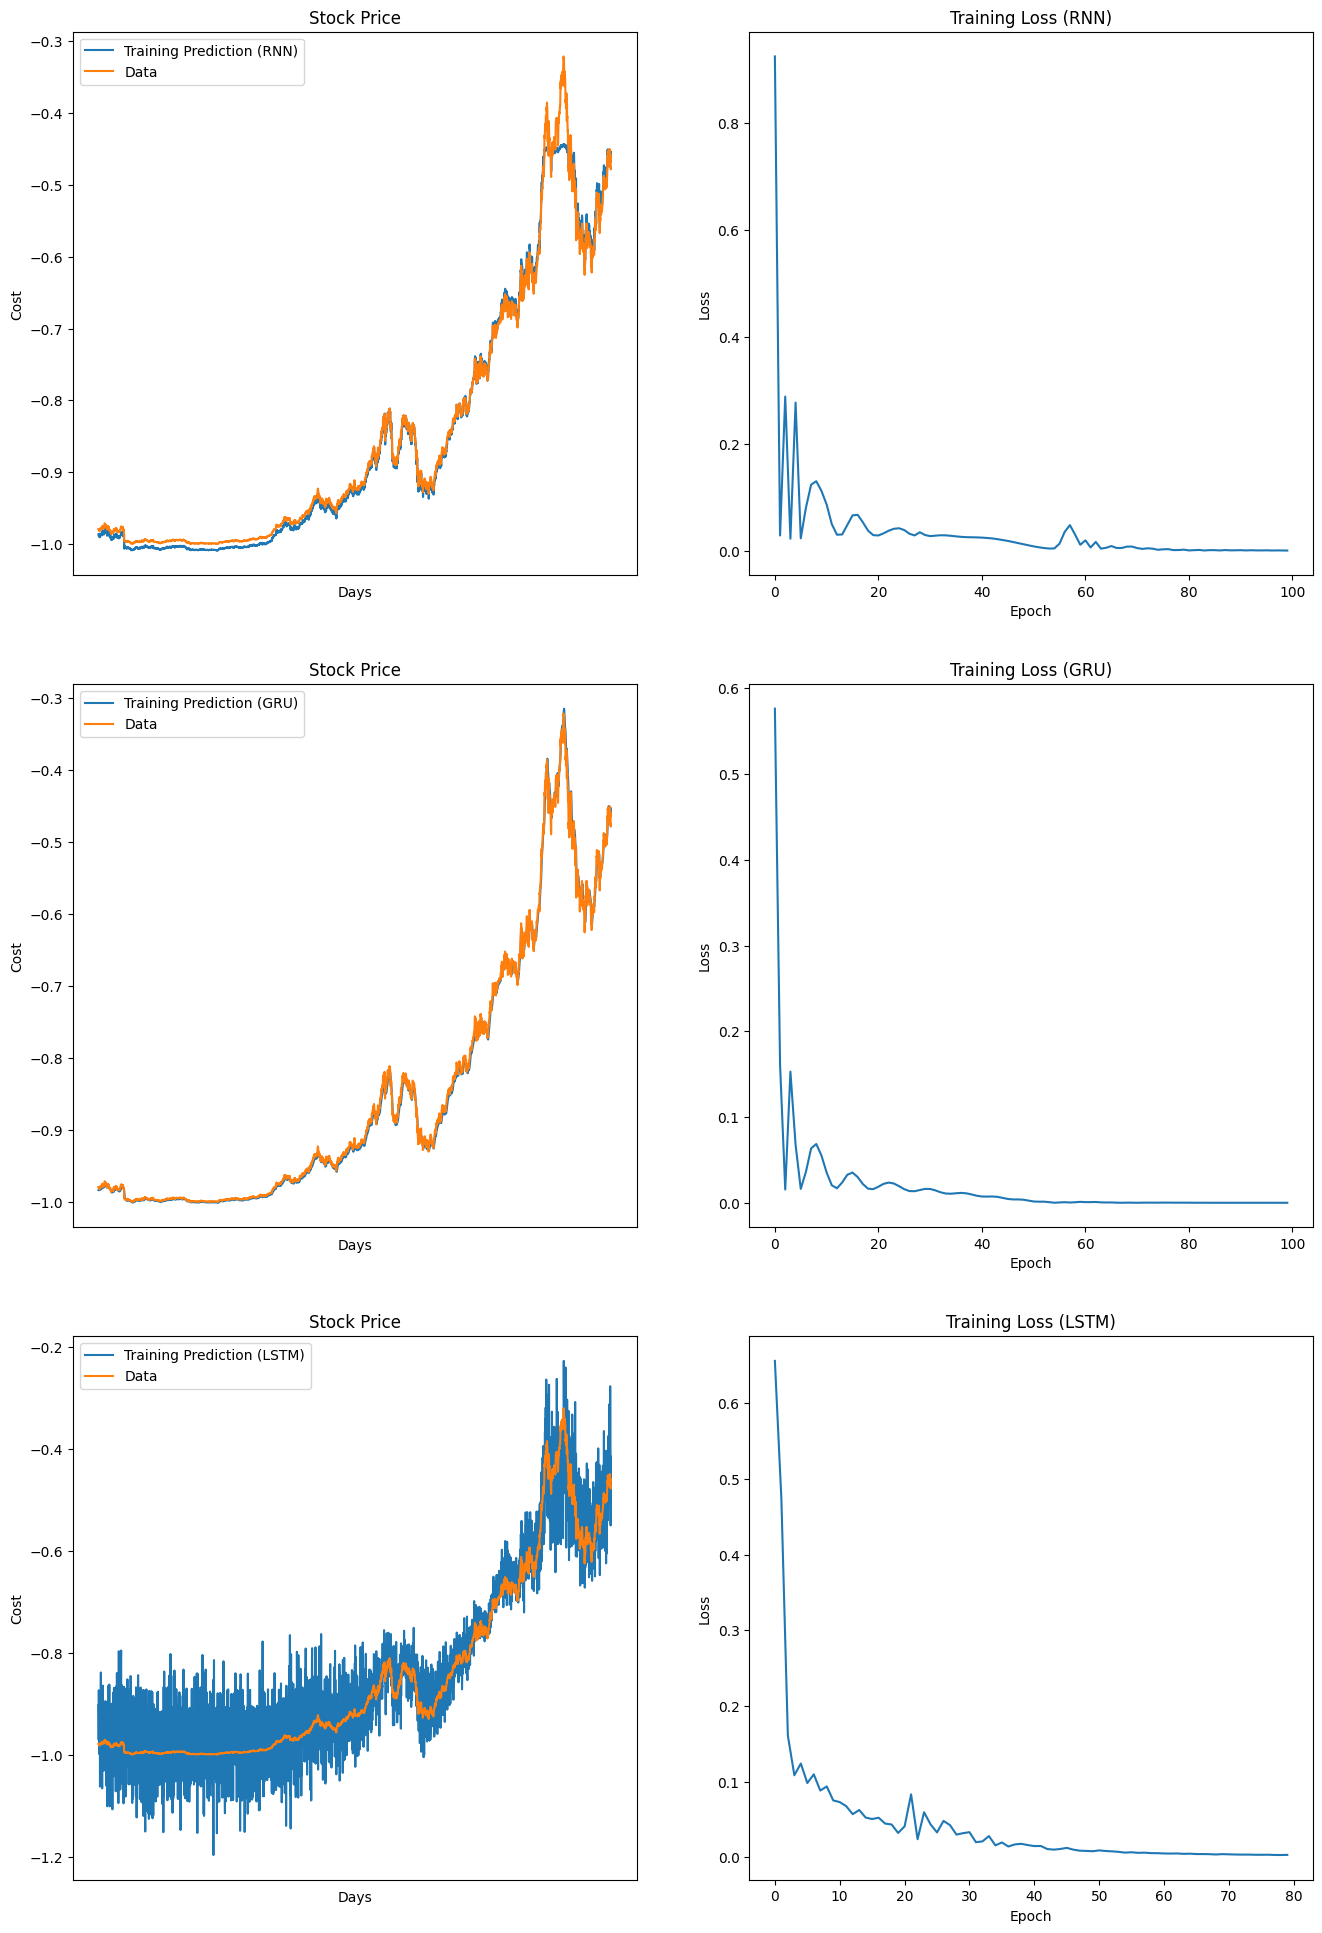

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(16, 24))
# RNN
ax[0][0].plot(range(output_rnn.shape[0]), output_rnn.detach(), label="Training Prediction (RNN)")
ax[0][0].plot(range(train_y.shape[0]), train_y, label="Data")
ax[0][0].set_xticks([], color="white")
ax[0][0].set_xlabel("Days")
ax[0][0].set_ylabel("Cost")
ax[0][0].set_title("Stock Price")
ax[0][0].legend(loc="upper left")
ax[0][1].plot(range(len(hist_rnn)), hist_rnn)
ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Loss")
ax[0][1].set_title("Training Loss (RNN)")
# GRU
ax[1][0].plot(range(output_gru.shape[0]), output_gru.detach(), label="Training Prediction (GRU)")
ax[1][0].plot(range(train_y.shape[0]), train_y, label="Data")
ax[1][0].set_xticks([], color="white")
ax[1][0].set_xlabel("Days")
ax[1][0].set_ylabel("Cost")
ax[1][0].set_title("Stock Price")
ax[1][0].legend(loc="upper left")
ax[1][1].plot(range(len(hist_gru)), hist_gru)
ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Loss")
ax[1][1].set_title("Training Loss (GRU)")
# LSTM
ax[2][0].plot(range(output_lstm.shape[0]), output_lstm.detach(), label="Training Prediction (LSTM)")
ax[2][0].plot(range(train_y.shape[0]), train_y, label="Data")
ax[2][0].set_xticks([], color="white")
ax[2][0].set_xlabel("Days")
ax[2][0].set_ylabel("Cost")
ax[2][0].set_title("Stock Price")
ax[2][0].legend(loc="upper left")
ax[2][1].plot(range(len(hist_lstm)), hist_lstm)
ax[2][1].set_xlabel("Epoch")
ax[2][1].set_ylabel("Loss")
ax[2][1].set_title("Training Loss (LSTM)")
plt.show()